The idea to create this model was sparked by a tweet: https://twitter.com/fchollet/status/711594805692792832

I studied the following resources to be able to finish the model:
0. http://artint.info/html/ArtInt_265.html
1. https://edersantana.github.io/articles/keras_rl/
2. http://www.nervanasys.com/demystifying-deep-reinforcement-learning/
3. http://keras.io/

Here's a gif of the model playing a few games of catching fruit:
<img src="files/fruit.gif" />

Btw, I really, *really* liked Eder Santana's idea to apply big idea's to toy examples. I hope to do this more often to feed my fingerspitzengefühl.

In [9]:
from random import sample as rsample

import numpy as np

from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten
from keras.layers import Input
from keras.optimizers import SGD, RMSprop
from keras import backend as K
import gym
import matplotlib.pyplot as plt
from skimage import color
from scipy.misc import imresize


%matplotlib inline

K.set_image_dim_ordering('tf')

In [10]:
env = gym.make('Breakout-v0')
print env.observation_space

img = env.reset()
print img.shape

def grayAndResize(img):
    gray = color.rgb2grey(img)
    newImg = imresize(gray, (84, 84))
    return newImg

def stackIt(images):
    stage = np.zeros(shape = (1, 84, 84, 4))
    for k, img in enumerate(images):
        #print "Image shape", type(img)
        stage[0, :, :, k] = grayAndResize(img)
    return stage

[2017-04-11 18:11:34,966] Making new env: Breakout-v0


Box(210, 160, 3)
(210, 160, 3)


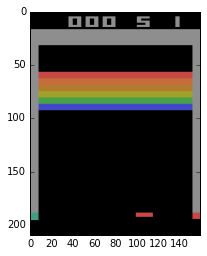

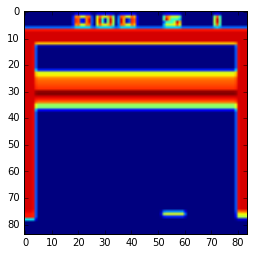

6
(84, 84) (1, 84, 84, 4)


In [11]:
plt.imshow(img)
plt.show()

images = stackIt([img, img, img, img])

images = images

plt.imshow(images[0, :, :, 1])
plt.show()
print env.action_space.n
print images[0, :, :, 1].shape, images.shape

In [12]:
           
def experience_replay(batch_size):
    """
    Coroutine of experience replay.
    
    Provide a new experience by calling send, which in turn yields 
    a random batch of previous replay experiences.
    """
    memory = []
    while True:
        experience = yield rsample(memory, batch_size) if batch_size <= len(memory) else None
        memory.append(experience)


In [13]:
def build_model(STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT, output_size ,dir = None):
    model = Sequential()
    model.add(Convolution2D(32, (8, 8), subsample=(4, 4), border_mode='same', activation='relu', input_shape = (84, 84, 4)))
    model.add(Convolution2D(32, 4, 4, subsample=(2, 2), border_mode='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(6))
    
    return model

In [19]:
nb_epochs = 1000
batch_size = 128
epsilon = .8
gamma = .8
K_frames = 4 #frames to skip each step

model  = build_model(STATE_LENGTH = K_frames, FRAME_WIDTH = 84, FRAME_HEIGHT = 84,output_size=env.action_space.n)
model.compile(RMSprop(), 'MSE')

exp_replay = experience_replay(batch_size)
exp_replay.next()  # Start experience-replay coroutine

loss = 0
rewards = 0
q_values = 0

for i in xrange(nb_epochs):
    
    
    if(epsilon > 0.05):
        epsilon = epsilon*0.95
    
    #ep = episode()
    #S, won = ep.next()  # Start coroutine of single entire episode
    action = np.random.randint(0, 6) #first action of epoch is random
    S = env.reset()
    #print S
    
    print 'Epoch ', i + 1, 'loss:', loss, "Reward:", rewards, "Total Q:", q_values, "Epsilon", epsilon     
    rewards = 0
    loss = 0.
    q_values = 0
    done = 0
    
    try:
        while True:
            
            ls = list()
            ls.append(S)
            
            action = np.random.randint(0, 6) 
            if np.random.random() < epsilon:
                # Get the index of the maximum q-value of the model.
                # Subtract one because actions are either -1, 0, or 1 #DONT DO THAT
                
                for i in range(K_frames-1):
                    s, r, done, info = env.step(action)
                    ls.append(s)
                    rewards+=r

                    if(done):
                        done = True
                        break
                    #print s.shape
                S = stackIt(ls)
                action = np.argmax(model.predict(S))
            else:
                
                for i in range(K_frames-1):
                    s, r, done, info = env.step(action)
                    ls.append(s)
                    rewards+=r

                    if(done):
                        done = True
                        break
                    #print "Tam of s when not epsilon: ", s.shape
                S = stackIt(ls)
                
            if(done):
                done = True
                break
            ## GETTING NEXT STATE ##
            S_prime, r, done, info = env.step(action)
            ls = list()
            ls.append(S_prime)
            
            for i in range(K_frames-1):
                s, r, done, info = env.step(action)
                ls.append(s)
                rewards+=r
                if(done):
                    done = True
                    break
                #print "Tam of s when not epsilon: ", s.shape
            if(done):
                done = True
                break
            S_prime = stackIt(ls)
            
            experience = (S, action, r, S_prime)
            
            S_prime, r, done, info = env.step(action)
            S = S_prime
            
            batch = exp_replay.send(experience)
            
            if batch:
                inputs = []
                targets = []
                for s, a, r, s_prime in batch:
                    # The targets of unchosen actions are the q-values of the model,
                    # so that the corresponding errors are 0. The targets of chosen actions
                    # are either the rewards, in case a terminal state has been reached, 
                    # or future discounted q-values, in case episodes are still running.
                    rewards +=r
                    t = model.predict(s)
                    #print t, a, t.shape
                    t[0][a] = r
                    #print a
                    if not r:
                        t[0][a] = r + gamma * np.argmax(model.predict(s_prime))
                    targets.append(t[0])
                    inputs.append(s[0])
                q_values += np.sum(targets)
                loss += model.train_on_batch(np.array(inputs), np.array(targets))
            #print loss
    except StopIteration:
        pass
    if (i + 1) % 100 == 0:
        print 'Epoch ', i + 1, 'loss:', loss


Epoch  1 loss: 0 Reward: 0 Total Q: 0 Epsilon 0.76
Epoch  2 loss: 0.0 Reward: 1.0 Total Q: 0 Epsilon 0.722
Epoch  3 loss: 0.0 Reward: 1.0 Total Q: 0 Epsilon 0.6859
Epoch  4 loss: 0.0 Reward: 1.0 Total Q: 0 Epsilon 0.651605
Epoch  5 loss: 0.0 Reward: 0.0 Total Q: 0 Epsilon 0.61902475
Epoch  6 loss: 110945.193522 Reward: 15.0 Total Q: -64844.2640514 Epsilon 0.5880735125
Epoch  7 loss: 93.7624510527 Reward: 27.0 Total Q: 24316.5298462 Epsilon 0.558669836875
Epoch  8 loss: 93.2302484661 Reward: 36.0 Total Q: 22355.3087769 Epsilon 0.530736345031
Epoch  9 loss: 55.2916820645 Reward: 54.0 Total Q: 53490.2181396 Epsilon 0.50419952778
Epoch  10 loss: 12.3516474366 Reward: 23.0 Total Q: 25612.9856567 Epsilon 0.478989551391
Epoch  11 loss: 10.1721744686 Reward: 31.0 Total Q: 36799.166626 Epsilon 0.455040073821
Epoch  12 loss: 203.027121812 Reward: 15.0 Total Q: 36566.367691 Epsilon 0.43228807013
Epoch  13 loss: 4.57542561367 Reward: 10.0 Total Q: 39777.2330322 Epsilon 0.410673666624
Epoch  14 los

KeyboardInterrupt: 

In [20]:
print model.layers[0]

In [21]:
model.save_weights('breakout.h5')

In [ ]:
def save_img():
    frame = 0
    while True:
        screen = (yield)
        plt.imshow(screen[0], interpolation='none')
        plt.savefig('images/%03i.png' % frame)
        frame += 1
    
img_saver = save_img()
img_saver.next()

for _ in xrange(10):
    g = episode()
    S, _ = g.next()
    img_saver.send(S)
    try:
        while True:
            act = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1
            S, _ = g.send(act)
            img_saver.send(S)

    except StopIteration:
        g.close()

img_saver.close()
